Created on Thu Nov 19 18:42:46 2020

@author: dariograna

Reference: Grana and de Figueiredo, 2021, SeReMpy

In this script we apply the Bayesian linearized AVO inversion method (Buland and Omre, 2003) to predict the elastic properties (P- and S-wave velocity and density) from seismic 
data.

# Seismic Inversion

In [1]:
from numpy import matlib
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np

import SeReMpy
from SeReMpy.Inversion import *

## Available data and parameters

In [2]:
# Load data (seismic data and time)
ds = np.loadtxt('Data/data3seis.dat')
TimeSeis = ds[:,0].reshape(-1, 1)
Sfull = ds[:,1].reshape(-1, 1)

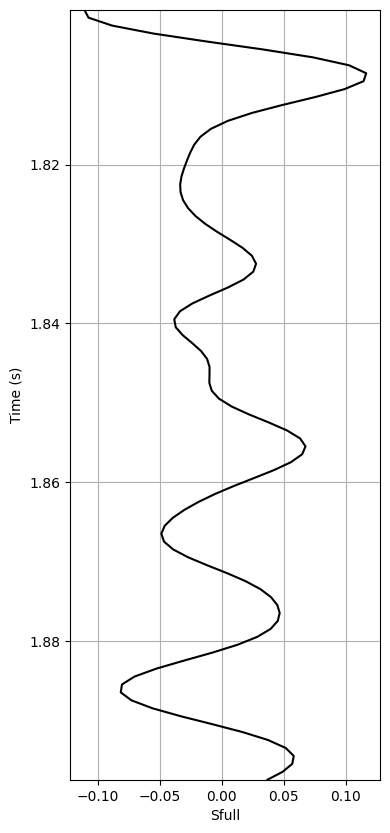

In [3]:
#% Plot seismic data
plt.figure(figsize=(4,10))
plt.plot(Sfull, TimeSeis, 'k')
plt.grid()
plt.ylim(max(TimeSeis),min(TimeSeis))
plt.xlabel('Sfull')
plt.ylabel('Time (s)')
plt.show()

In [4]:
dl = np.loadtxt('Data/data3log.dat')
Vp = dl[:,0].reshape(-1, 1)
Rho = dl[:,2].reshape(-1, 1)
Ip = Vp*Rho
Time = dl[:,3].reshape(-1, 1)

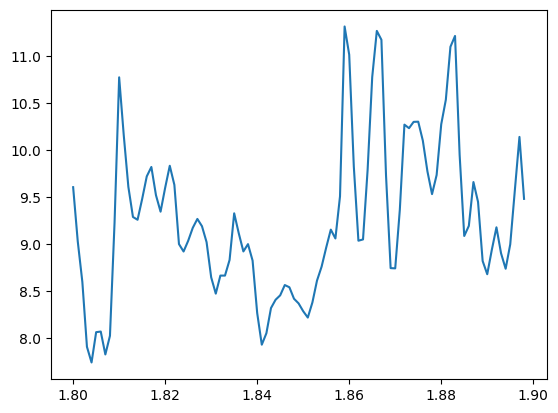

In [5]:
plt.plot(Time, Ip)

## Initial parameters

In [6]:
# number of samples (elastic properties)
nm = Sfull.shape[0]+1
nd = Sfull.shape[0]
# number of variables
nv = 1
# reflection angles 
theta = 0
ntheta = 1
# time sampling
dt = TimeSeis[1] - TimeSeis[0]
# error variance
varerr = 10**-3
sigmaerr = varerr * np.eye(ntheta * (nm - 1))

## Wavelet

In [7]:
freq = 45
ntw = 64
wavelet, tw = RickerWavelet(freq, dt, ntw)

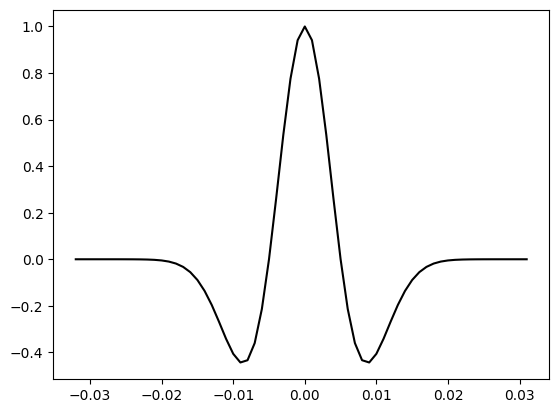

In [8]:
plt.plot(tw, wavelet, color='black')

## Background Model

In [9]:
#% Prior model (filtered well logs)
nfilt = 3
cutofffr = 0.04
b, a = signal.butter(nfilt, cutofffr)
Ipprior = signal.filtfilt(b, a, np.squeeze(Ip))

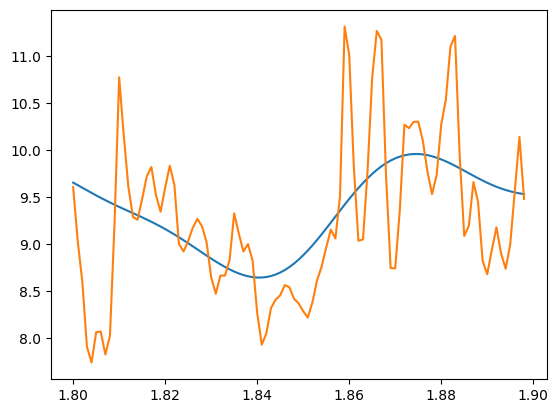

In [10]:
plt.plot(Time, Ipprior)
plt.plot(Time, Ip)

## Spatial correlation matrix

In [11]:
corrlength = 5 * dt
trow = np.matlib.tile(np.arange(0, nm * dt, dt), (nm, 1))
tcol = np.matlib.tile(trow[0,:].reshape(nm,1), (1, nm))
tdis = abs(trow - tcol)
sigmatime = np.exp(-(tdis / corrlength) ** 2)
sigma0 = np.cov(np.hstack([np.log(Ip)]).T)
sigmaprior = np.kron(sigma0, sigmatime)

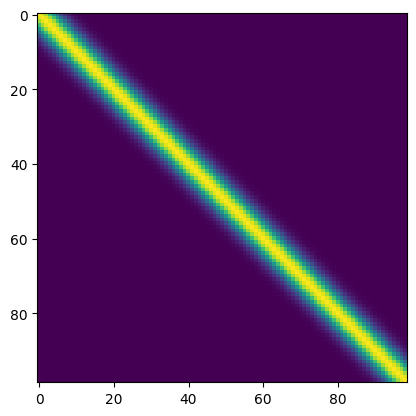

In [12]:
plt.imshow(sigmaprior)

## Inversão Bayesiana Acústica

In [13]:
D = DifferentialMatrix(nm, nv)
D

array([[-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.]])

In [14]:
A = np.diag(np.ones(nd)*0.5)
A

array([[0.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.5, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0.5, 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0.5]])

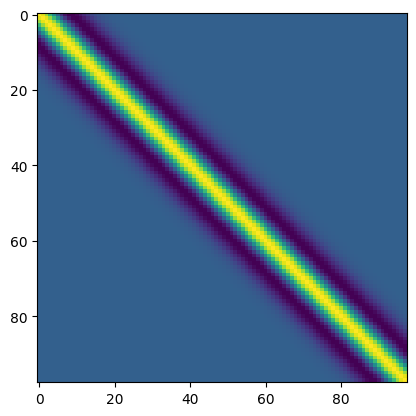

In [15]:
W = WaveletMatrix(wavelet, nm, ntheta=1)
plt.imshow(W)

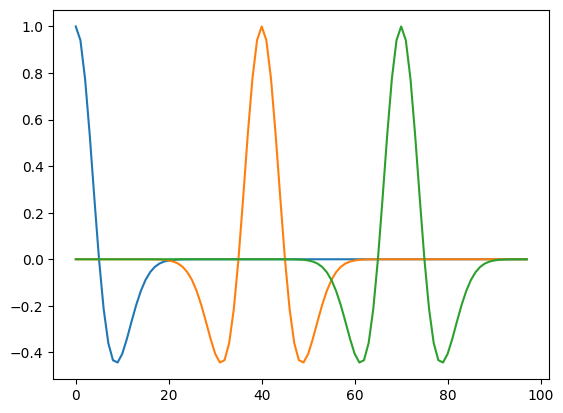

In [16]:
plt.plot(W[0])
plt.plot(W[40])
plt.plot(W[70])

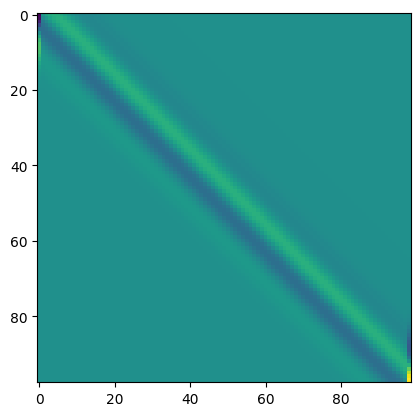

In [17]:
G = W @ A @ D
plt.imshow(G)

In [18]:
def BayesianInversion(Sfull, m, sigmaprior, sigmaerr, G):
    mdobs = (G @ m)
    sigmadobs = (G @ sigmaprior @ G.T) + sigmaerr
    mpost =  m + (G @ sigmaprior).T @ np.linalg.lstsq(sigmadobs, (Sfull-mdobs), rcond=10e-3)[0]
    return np.exp(mpost).T

In [19]:
Seis = np.vstack([Sfull])
mmap = BayesianInversion(Sfull, np.log(Ipprior).reshape(-1,1), sigmaprior, sigmaerr, G)
mmap.shape

(1, 99)

Text(0.5, 0, 'Time (ms)')

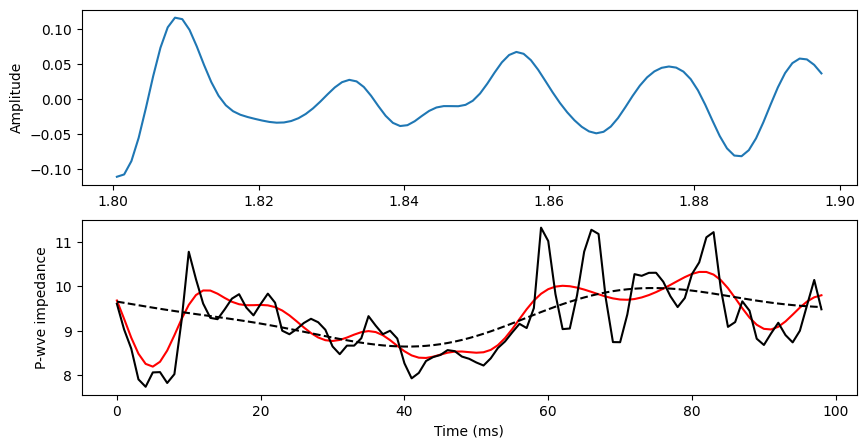

In [20]:
fig, ax = plt.subplots(2,1, figsize=(10,5))
ax[0].plot(TimeSeis, Sfull)
ax[0].set_ylabel('Amplitude')

ax[1].plot(mmap.T, color='red')
ax[1].plot(Ip, 'black')
ax[1].plot(Ipprior, 'k--')
ax[1].set_ylabel('P-wve impedance')
ax[1].set_xlabel('Time (ms)')